Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# группируем наши данные по дате и группе и вычисляем количество пользователей, заходивших на 
# сайт, и суммарное количество совершённых целевых действий.
daily_data = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})


display(daily_data.head(1))
display(daily_data.tail(1))

,date,group,users_count,purchase,price
0,2021-01-02,A,2894,362,29720000


,date,group,users_count,purchase,price
45,2021-01-24,B,3727,449,39280000


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
converted_data= daily_data.groupby('group').agg({
    'users_count':'sum',
    'purchase':'sum',
    'price':'sum'})
display(converted_data)

,users_count,purchase,price
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


- Количество посещений сайта в группе А составило 147 202 (49.99%), в группе В - 147 276 (50.01%)
- Количество покупок в группе А составило 17 723, в группе В - 17 514
- Общая сумма покупок в группе А составила 1 436.26 млн.руб., в группе В - 1 554.10 млн.руб.

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
# выделяем данные группы А и группы B
data_a = data[data['group'] == 'A']
data_b = data[data['group'] == 'B']

# создаём множество из датафрейма 
values_a = set(data_a['user_id']) 
values_b = set(data_b['user_id'])

# Метод sets.intersection() позволяет найти пересечение множества с одной или более 
# последовательностями поддерживающих итерирование. Метод возвращает новое множество с элементами,
# общими для множества values_a и values_b
user_intersection = values_a.intersection(values_b)
print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

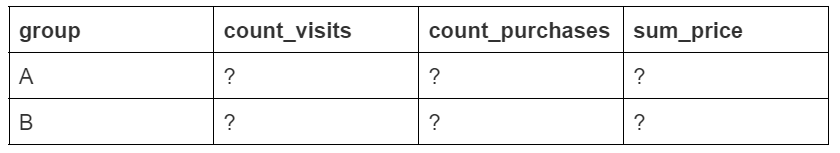
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
# Расчет статистик для каждой группы и Переименование столбцов
data_7_5 = updated_data.groupby('group').agg(count_visits=('user_id', 'count'),
                                       count_purchases=('purchase', 'sum'),
                                       sum_price=('price', 'sum')).reset_index()

display(data_7_5)

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

- Количество посещений обоих вариантов практически равны,  А=145307	и В=145381. Что говорит о том, что выборки сбалансированы.


## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
data_7_5['conversion'] = round(data_7_5['count_purchases']/data_7_5['count_visits'] * 100, 2)
data_7_5['mean_check'] = round(data_7_5['sum_price']/data_7_5['count_purchases'],)
data_7_5.head()

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

#### <center>Выводы:<center>
- По конверсии вариант А эффективней, но это не точно, т.к. нужно смотреть статистические тесты, они покаждут более точный ответ в рамках статистической погрешности.
- По среднему чеку (повышению прибыли) вариант В значительно превосходит вариант А

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
# Рассчет сводной таблицы
# сводная таблица: строки - цена, столбцы - группы, значения - кол-во покупок
pivot_table = updated_data.pivot_table(index='price', columns='group', values='purchase', aggfunc='sum')
pivot_table.head()

group,A,B
price,,
0,0,0
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Зависимость кол-ва продаж от группы и цены тура')

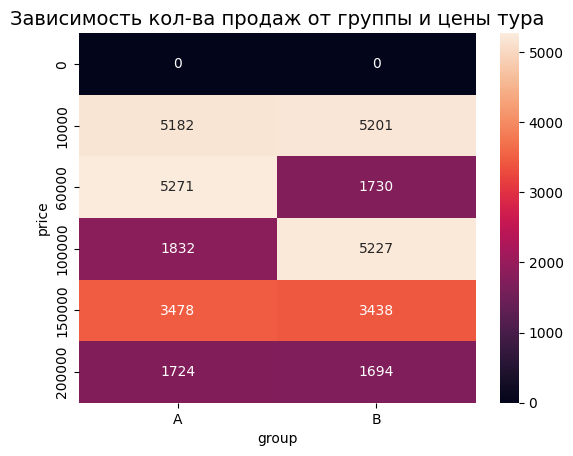

In [11]:
# Отрисовка тепловой карты
ax = sns.heatmap(pivot_table, annot=True, fmt='d')
# и добавим аннотацию
ax.set_title('Зависимость кол-ва продаж от группы и цены тура', fontdict={'size': 14})

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

#### <center>Выводы:<center> 
Напомним, какие данные по стоимости туров у нас имеются:

Таиланд — 100000 рублей;
    
Турция — 60000 рублей;
    
Мальдивы — 200000 рублей;
    
Санкт-Петербург — 10000 рублей;
    
Камчатка — 150000 рублей.
    
Группа А: самыми популярными направлениями оказались Петербург (10 тыс руб) и Турция (60 тыс руб). Далее идёт Камчатка (150 тыс руб). На третьем месте Таиланд (100 тыс руб) и Мальдивы (200 тыс руб).

Группа В: Наиболее популярны Петербург и Таиланд (10 тыс и 100 тыс соответственно), далее Камчатка, на третьем месте Мальдивы и Турция.

Нельзя сказать, что есть однозначная зависимость между ценой тура и кол-вом покупок. Это справедливо для обеих групп.

Если сравнивать группы между собой, видим, что по турам в Петербург, Мальдивы и Камчатку покупательская способность примерно одинаковая. При этом путешественники из группы А предпочли Турцию Таиланду (5.2 тыс vs 1.8 тыс). Путешественники из группы В - наоборот (1.7 тыс vs 5.2 тыс). На тепловой это отчётливо видно, цвета "меняются местами" для соответствующих значений цены.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
# Используем датафрейм из задания 7.4 'updated_data'
data_7_8 = updated_data.groupby(['date','group']).agg(count_visits=('user_id', 'count'),
                                       count_purchases=('purchase', 'sum'),
                                       sum_price=('price', 'sum')).reset_index() 
# Добавим в таблицу информацию о ежедневной конверсии и ежедневном среднем чеке
data_7_8['conversion'] = round(data_7_8['count_purchases']/data_7_8['count_visits'] * 100, 2)
data_7_8['mean_check'] = round(data_7_8['sum_price']/data_7_8['count_purchases'],)

data_7_8.info()
display(data_7_8[data_7_8['date'] == '2021-01-03'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             46 non-null     datetime64[ns]
 1   group            46 non-null     object        
 2   count_visits     46 non-null     int64         
 3   count_purchases  46 non-null     int64         
 4   sum_price        46 non-null     int64         
 5   conversion       46 non-null     float64       
 6   mean_check       46 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 2.6+ KB


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
# вычисляем кумулятивное количество посещений страницы
data_7_8['cum_count_visits'] = data_7_8.groupby(['group'])['count_visits'].cumsum()

# вычисляем кумулятивное количество покупок
data_7_8['cum_count_purchases'] = data_7_8.groupby(['group'])['count_purchases'].cumsum()

# вычисляем кумулятивную сумму покупок
data_7_8['cum_sum_price'] = data_7_8.groupby(['group'])['sum_price'].cumsum()

# вычисляем кумулятивную конверсию и кумулятивный средний чек
data_7_8['cum_conversion'] = data_7_8['cum_count_purchases']/data_7_8['cum_count_visits'] * 100
data_7_8['cum_mean_check'] = round(data_7_8['cum_sum_price']/data_7_8['cum_count_purchases'],)
data_7_8.head()

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.578837,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0,2861,345,29660000,12.058721,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.714286,82575.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0,9480,1099,95620000,11.592827,87006.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.900599,81668.0


In [14]:
# Какая кумулятивная конверсия была в группе B на 20 января? 
display(data_7_8[data_7_8['date'] == '2021-01-20'])

# Какой кумулятивный средний чек был в группе А на 12 января 2021 года?
display(data_7_8[data_7_8['date'] == '2021-01-12'])

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
36,2021-01-20,A,6533,749,58710000,11.46,78385.0,121506,14561,1179590000,11.983770,81010.0
37,2021-01-20,B,6685,790,69250000,11.82,87658.0,121857,14496,1286900000,11.895911,88776.0


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
20,2021-01-12,A,6540,795,68460000,12.16,86113.0,68852,8198,668070000,11.906698,81492.0
21,2021-01-12,B,6635,807,70560000,12.16,87435.0,69251,8236,727670000,11.892969,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

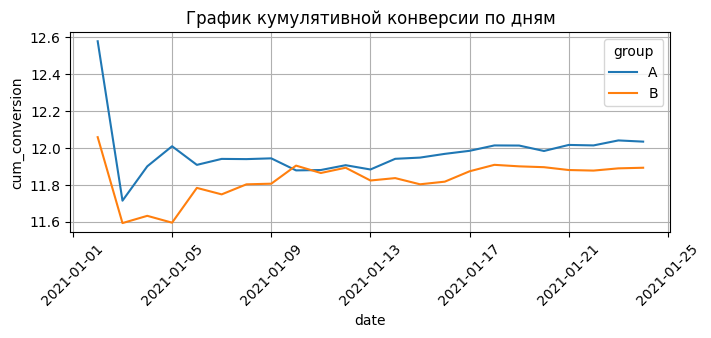

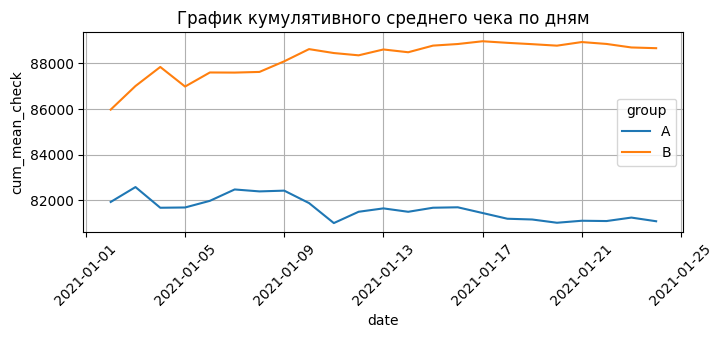

In [15]:
# А теперь построим графики кумулятивной конверсии по дням в каждой группе:

# создаём фигуру размером 6x2
fig = plt.figure(figsize=(6, 2))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=data_7_8, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

# А теперь построим графики кумулятивного среднего чека по дням в каждой группе:

# создаём фигуру размером 6x2
fig = plt.figure(figsize=(6, 2))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=data_7_8, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

#### <center>Выводы:<center>
- Значения A/B-теста стабилизировались во времени, для кумулятивной конверсии после 17 января, а для кумулятивного среднего чека - 12 января.
- Кумулятивной конверсия в группе А немного выше(больше), а вот кумулятивный средний чек в группе В значительно больше
- Можно считать A/B тестирование завершённым.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [16]:
# Предварительные данные мы взяли из задания 7.5

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=data_7_5['count_purchases'], #число "успехов"
    nobs=data_7_5['count_visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

#### <center>Выводы:<center>
Почему выбрази Z-тест?
- Данные распределены по нормальному закону
- тип переменной - количественная
- сравниваются 2 группы
- кол-во выборок больше 30

По результатам проведенного статистического теста можно сказать, что статистической разницы между конверсиями в группах А и B нет. Для более точного ответа нужно провести расчёты для доверительного интервала конверсий

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

Для вычесления доверительного интервала для конверсии буду использовать:
- доверительный интервал для пропорции
- данные из задания 7.4 `updated_data`
- предварительно созданную функцию `proportions_conf_interval()`для доверительного интервала конверсий
- Создадим функцию `diff_proportions_conf_interval()` для доверительного интервала разницы конверсий 

In [17]:
# Для удобства создадим отдельные таблицы для каждой из групп пользователей:

#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

In [18]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [19]:
# Теперь применим нашу функцию к данным группы А и группы B:

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [20]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [21]:
# Вызовем функцию и построим интересующий нас доверительный интервал:

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

#### <center>Выводы:<center>
- Итак, можно сказать, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.87 % до 12.20 %, а конверсия группы B лежит в интервале от 11.73 % до 12.06 %.
- Истинные значения конверсии, которые нас интересуют, могут попасть в зону пересечения. То есть мы не можем однозначно сказать, есть ли разница в конверсиях. Такой результат согласуется с результатом проведённого выше z-теста.
- разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем: статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

Для проверки стат. разницы между размерами средних чеков сначала выясним, имеют ли наши данные нормальное распределение. Это повлияет на выбор теста.

Для проверки гипотезы о нормальности распределения средних чеков применим тест Шапиро-Уилка, т.к. имеем дело с количественными данными

In [22]:
# Определим гипотезы и уровень значимости
H0 = 'Данные распределены нормально'
H1 = 'Данные не распределены нормально (отвергаем H0)'

alpha = 0.05

# Подготовка данных о среднем чеке
shapiro_a = data_7_8[data_7_8['group'] == 'A']['mean_check']
shapiro_b = data_7_8[data_7_8['group'] == 'B']['mean_check']

# Тест
w_a, p_a = shapiro(shapiro_a)
print('p(group A)=%.3f' % p_a)

w_b, p_b = shapiro(shapiro_b)
print('p(group B)=%.3f' % p_b)

p(group A)=0.253
p(group B)=0.094


#### <center>Выводы:<center>
- В обоих случаях полученное значение p (вероятность принять ошибочное решение, отвергнув нулевую гипотезу), больше уровня стат. значимости 0.05.
- Принимаем нулевую гипотезу о нормальности распределения среднего чека в обоих группах.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

Имеем данные за 23 дня для каждой группы:
- размер выборки меньше 30, 
- данные числовые, непрерывные, нормально распределены. 
- Данные сравниваются по одному и тому же параметру. 

Для проверки гипотезы о равенстве средних чеков в двух группах будем использовать T-тест.

In [23]:
# Определим гипотезы и уровень значимости
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'

aplpha = 0.05

# Тест
st_t, p = ttest_ind(shapiro_a, shapiro_b, equal_var=True)

# Интерпретация
p = round(p,5)

if p>alpha:
    print(f"{p} > {alpha}. Не можем отвергнуть нулевую гипотезу. {H0}")
else:
    print(f"{p} <= {alpha}. Отвергаем нулевую гипотезу. {H1}")


0.0 <= 0.05. Отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

#### <center>Выводы:<center>
Если мы отвергнем нулевую гипотезу, вероятность ошибки будет равна 0 с точностью до 5 знаков после запятой.

Поэтому отвергаем эту гипотезу и принимаем альтернативную - есть статистическая разница в средних чеках двух групп, средний чек в группе А меньше, чем в группе В.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [24]:
# 95%-ые доверительные интервалы для средних чеков обеих групп

def mean_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 # число степеней свободы
    alpha = 1 - gamma # уровень значимости

    t_crit = -t.ppf(alpha/2, k) # табличное значение t-критическое
    eps = t_crit * x_std/(n**0.5) # погрешность
    lower_bound = x_mean - eps # нижняя граница интервала
    upper_bound = x_mean + eps  # верхняя граница интервала
    confidence_interval = (round(lower_bound), round(upper_bound))
    return confidence_interval


n = data_7_8.shape[0]/2 # размер выборки

# Группа А
x_mean = shapiro_a.mean() # выборочное среднее
x_std = shapiro_a.std() # выборочное стандартное отклонение
conf_int = mean_conf_interval(n, x_mean, x_std)
print('Доверительный интервал для среднего чека группы А: {}'.format(conf_int)) # выводим результат

# Группа B
x_mean = shapiro_b.mean() # выборочное среднее
x_std = shapiro_b.std() # выборочное стандартное отклонение
conf_int = mean_conf_interval(n, x_mean, x_std)
print('Доверительный интервал для среднего чека группы B: {}'.format(conf_int)) # выводим результат

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

#### <center>Выводы</center>
- Доверительные интервалы не пересекаются. 
- С вероятностью 95% истинные значения средних чеков обеих групп лежат в соответствующих доверительных интервалах, **и между этими значениями существует статистически значимая разница**.


# <center>Общий вывод по результатам AB теста</center>

- Был проведён AB тест на выборке достаточного размера для двух групп.
- Сравнивалась эффективность двух вариантов посадочной страницы по двум параметрам: конверсия и средний чек.
- Результаты теста показали, что нет статистической разницы между конверсией в двух группах, но есть разница в размерах среднего чека - средний чек в группе В выше.
- Таким образом, вариант дизайна страницы В в целом выглядит эффективнее.